<a href="https://colab.research.google.com/github/aubricot/CV_for_flower_CT/blob/main/Cacao_Whole_Flower_Seg_unetr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using MONAI Label for shape prediction of flowers from micro-CT images
---   
*Last Updated 15 Mar 2023*  
-Runs in Python 3 with Monai 1.5-   
This notebook uses a dataset of micro-CT images and segementations (both as nifti files, .nii.gz) to custom train a UNETR Computer Vision Model ([Hatamizadeh et al. 2021](https://arxiv.org/abs/2103.10504)) using the [MONAI Label](https://github.com/aubricot/computer_vision_with_eol_images/tree/master/classification_for_image_tagging) framework. U-Nets are a type of Convolutional Neural Network (CNN) shaped like a "U" with pairings of encoders (contracting path) and decoders (expanding path) who have gained popularity in recent years as a tool for segmentation of 3D image datasets ([Tomar 2021](https://medium.com/analytics-vidhya/what-is-unet-157314c87634&ved=2ahUKEwjeiK-myoyMAxX-QzABHb85DmQQFnoECBEQAQ&usg=AOvVaw1V_3fmv2Fckxy0QTuwS6LM)). UNETR has a similar network design/shape for the encoder and decoder as a U-Net, but UNEt TRansformers (UNETR), uses a transformer as the encoder.

Notes
* dd

_References_

* [Hatamizadeh et al. 2021](https://arxiv.org/abs/2103.10504)   
* [Tomar 2021](https://medium.com/analytics-vidhya/what-is-unet-157314c87634&ved=2ahUKEwjeiK-myoyMAxX-QzABHb85DmQQFnoECBEQAQ&usg=AOvVaw1V_3fmv2Fckxy0QTuwS6LM)

_License_   
This notebook is licensed under an [MIT license](https://github.com/aubricot/CV_for_flower_CT/blob/master/LICENSE). Portions are modified from the MONAI Label [3D Multi-organ Segmentation with UNETR (BTCV Challenge)](https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/unetr_btcv_segmentation_3d.ipynb) following licensing terms under Copyright (c) MONAI Consortium and [Apache License, Version 2.0](http://www.apache.org/licenses/LICENSE-2.0).

The sections **X, Y, Z** were modified to better suit our needs. Google Colab form fields were also added, as well as tools to split the dataset train-validate-test, methods to save training outputs (trained models, notebook in its state for each train run as a txt file, and train graphs; named based on the train attempt number (ie the first train attempt files were saved as 01.ph, 01.txt, and 01.png).

## Installs & Imports
---

In [1]:
#@title Make sure runtime is set to GPU and High RAM
# Copyright (c) MONAI Consortium and [Apache License, Version 2.0](http://www.apache.org/licenses/LICENSE-2.0)
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Sat Mar 15 21:34:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             41W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
#@title Check how many workers are suggested for your system
# TO DO: Adjust num_workers throughout code to speed or slow performance based on available (cloud) hardware
import os

cpu_count = os.cpu_count()
if cpu_count is not None:
    max_num_worker_suggest = cpu_count

print("Suggested max number of workers is: ", max_num_worker_suggest)

Suggested max number of workers is:  12


In [3]:
#@title Choose where to save results

# Use dropdown menu on right
save = "in my Google Drive" #@param ["in my Google Drive", "in Colab runtime (files deleted after each session)"]

# Mount google drive to export image tagging file(s)
if 'Google Drive' in save:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)

# Type in the path to your project wd in form field on right
wd = "/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data" # @param ["/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data","/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/demo_data/Abdomen/Abdomen/RawData/data"] {"allow-input":true}
print("Working with data from: \n")
%cd $wd

Mounted at /content/drive
Working with data from: 

/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data


In [4]:
#@title Installs
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
!pip install nbconvert
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 89.7 MB/s eta 0:00:00


In [5]:
#@title Imports
import os
import shutil
import tempfile
import glob
import math
import time

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.utils import first
from monai.losses import DiceCELoss, DiceLoss
from monai.inferers import sliding_window_inference, SimpleInferer
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    CropForegroundd,
    EnsureChannelFirstd,
    EnsureType,
    EnsureTyped,
    FgBgToIndicesd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    RandSpatialCropd,
    Resized,
    ScaleIntensityRangePercentilesd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.layers import Act, Norm
from monai.networks.nets import UNETR, unet
from torch.optim import Adam, SGD
from monai.optimizers import Novograd
from monai.apps import download_and_extract
from monai.data import NibabelReader

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    ThreadDataLoader,
    Dataset,
    set_track_meta,
)

# Facilitate debugging by making GPU tell more useful information
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch

# Check that cuda is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available and being used.")
else:
    device = torch.device("cpu")
    print("CUDA is not available, using CPU instead.")

print_config()

CUDA is available and being used.
MONAI version: 1.5.dev2510
Numpy version: 1.26.4
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 19fadf962d87a21e1d0edf8d72299e82f7611140
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.14.1
Pillow version: 11.1.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.1
transformers version: 4.48.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, plea

In [6]:
#@title Set up data directory
os.environ['MONAI_DATA_DIRECTORY'] = wd
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = directory
print(f"root dir is: {root_dir}")

out_dir = wd + '/' + "results/"

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

print(f"out dir is: {out_dir}")

root dir is: /content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data
out dir is: /content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/results/


In [7]:
#@title Define functions

# Save each new training attempt results by name (TRAIN_SES_NUM)
def set_saved_model_path(out_dir = out_dir, saved_models_dir = "saved_models"):
    saved_models_wd = os.path.join(out_dir, saved_models_dir)
    if not os.path.exists(saved_models_wd):
        print("{} not found. Making saved models directory at: {}".format(saved_models_dir, saved_models_wd))
        os.mkdir(saved_models_wd)
    # Name folder to sort by attempt number (useful if many training runs)
    else:
        try:
            last_attempt = !ls $saved_models_wd | tail -n 1
            last_attempt = int(os.path.splitext(last_attempt[0])[0])
        except:
            last_attempt = 0
        if last_attempt < 9:
            TRAIN_SESS_NUM = "0" + str(last_attempt + 1)
        else:
            TRAIN_SESS_NUM = str(last_attempt + 1)

    saved_model_path = os.path.join(saved_models_wd, (TRAIN_SESS_NUM + ".pth"))
    print("Saving trained model results to: ", saved_model_path)

    return saved_model_path, TRAIN_SESS_NUM

# For pulling img and label file names from train/val dictionaries
def find_dict_idx_by_val(dict_list, key, val):
    for idx, dict in enumerate(dict_list):
        if key in dict and val in dict[key]:
            return idx

## Setup transforms for training and validation

In [ ]:
#@title Train-test-validation split
!pip install split-folders
import splitfolders

# List all files in dir before splitting
all_vols = os.listdir('./images/class1')
n = len(all_vols)
print("Training dataset size of N = ", n)

# Save list of files before split to txt file in your wd
with open("all_vols.txt", "w") as output:
    output.write(str(all_vols))
print("List of all files before splitting saved to: ", (wd + '/all_vols.txt'))

# Train-test-validation split (70% - 15% - 15%)
splitfolders.ratio("images", output="input", seed=n,
                   ratio=(0.7, 0.15, 0.15), group_prefix=None, move=False)

In [ ]:
#@title Move labels to their corresponding train-test-val folders to match images

# Get list of all labels
all_labs = os.listdir('./labels/class1')
all_labs = [os.path.splitext(os.path.splitext(file)[0])[0] for file in all_labs] # Remove .nii.gz extensions
all_labs = [file.removesuffix('_seg') for file in all_labs]

# Find which label files need to be moved to train-test-val and move them
train = os.listdir('./input/train/class1')
train = [os.path.splitext(os.path.splitext(file)[0])[0] for file in train] # Remove .nii.gz extensions
train = [file.removesuffix('_crop') for file in train]
train = [file.removesuffix('_cropped') for file in train]
train = [file.removesuffix('_crop_mask') for file in train]

test = os.listdir('./input/test/class1')
test = [os.path.splitext(os.path.splitext(file)[0])[0] for file in test] # Remove .nii.gz extensions
test = [file.removesuffix('_crop') for file in test]
test = [file.removesuffix('_cropped') for file in test]
test = [file.removesuffix('_crop_mask') for file in test]

val = os.listdir('./input/val/class1')
val = [os.path.splitext(os.path.splitext(file)[0])[0] for file in val] # Remove .nii.gz extensions
val = [file.removesuffix('_crop') for file in val]
val = [file.removesuffix('_cropped') for file in val]
val = [file.removesuffix('_crop_mask') for file in val]

train_mv = set(train) & set(all_labs)
test_mv = set(test) & set(all_labs)
val_mv = set(val) & set(all_labs)

# Move files to train
os.makedirs('input/train/class1/labels')
for file in train_mv:
    file_path = os.path.join('labels/class1', file + '_seg.nii.gz')
    target = os.path.join('input/train/class1/labels', file + '_seg.nii.gz')
    shutil.copy2(file_path, target)  # Preserves metadata
    print(f"Copied: {file_path} to {target}")

# Move files to test
os.makedirs('input/test/class1/labels')
for file in test_mv:
    file_path = os.path.join('labels/class1', file + '_seg.nii.gz')
    target = os.path.join('input/test/class1/labels', file + '_seg.nii.gz')
    shutil.copy2(file_path, target)  # Preserves metadata
    print(f"Copied: {file_path} to {target}")

# Move files to validation (val)
os.makedirs('input/val/class1/labels')
for file in val_mv:
    file_path = os.path.join('labels/class1', file + '_seg.nii.gz')
    target = os.path.join('input/val/class1/labels', file + '_seg.nii.gz')
    shutil.copy2(file_path, target)  # Preserves metadata
    print(f"Copied: {file_path} to {target}")

# Move all image files within train-test-val into images/
target = 'input/train/class1/images'
os.makedirs(target)
source = './input/train/class1'
files = os.listdir(source)
for file in files:
    shutil.move(os.path.join(source, file), target)
    print(f"Moved: {source} to {target}")

target = 'input/test/class1/images'
os.makedirs(target)
source = './input/test/class1'
files = os.listdir(source)
for file in files:
    shutil.move(os.path.join(source, file), target)
    print(f"Moved: {source} to {target}")

target = 'input/val/class1/images'
os.makedirs(target)
source = './input/val/class1'
files = os.listdir(source)
for file in files:
    shutil.move(os.path.join(source, file), target)
    print(f"Moved: {source} to {target}")

## Transform dataset

In [8]:
#@title Get dataset filepaths for train and validation
data_root = os.path.join(root_dir, "input")

train_images = sorted(glob.glob(os.path.join(data_root, "train/images", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_root, "train/labels", "*.nii.gz")))
val_images = sorted(glob.glob(os.path.join(data_root, "val/images", "*.nii.gz")))
val_labels = sorted(glob.glob(os.path.join(data_root, "val/labels", "*.nii.gz")))

train_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
val_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(val_images, val_labels)]
num_train = len(train_files)
num_val = len(val_files)

print("Training model with {} train images and {} validation images\n".format(num_train, num_val))
print(" Train images loaded from {} \n Train labels loaded from {} \n Validation images loaded from {} \n Validation labels loaded from {}".format(train_images, train_labels, val_images, val_labels))

Training model with 19 train images and 5 validation images

 Train images loaded from ['/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/input/train/images/THECAC_FBG_RF_0120a_220624_01_crop.nii.gz', '/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/input/train/images/THECAC_FBG_RF_0120a_220624_04_crop.nii.gz', '/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/input/train/images/THE_USDA_MAR_(10)UM_HR_SS_PTA(14d)_.nii.gz', '/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/input/train/images/THE_USDA_MAR_(10)UM_HR_SS_PTA(14d)_2_.nii.gz', '/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/input/train/images/THE_USDA_MAR_(7)UM_HR_SS_PTA(14d)_.nii.gz', '/content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/input/train/images/THE_USDA_MAR_(8)UM_HR_SS_PTA(14d)_2_.nii.gz', '/content/drive/MyDrive/

In [9]:
#@title Dataset Transforms

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(.05, .05, .05),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRangePercentilesd(
                keys="image",
                lower=10, upper=90, b_min=0, b_max=200,
                clip=False,
                relative=False,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(.05, .05, .05),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRangePercentilesd(
                keys="image",
                lower=10, upper=90, b_min=0, b_max=200,
                clip=False,
                relative=False,),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        #RandCropByPosNegLabeld(
            #keys=["image", "label"],
            #label_key="label",
            #spatial_size=(96, 96, 96),
            #pos=1,
            #neg=1,
            #num_samples=4,
            #image_key="image",
            #image_threshold=0,
       # ),
    ]
)

/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [10]:
#@title Transform datasets and read into cache for training

# Train Dataset
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_num=num_train, cache_rate=1.0, num_workers=8)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)

# Validation Dataset
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=num_val, cache_rate=1.0, num_workers=8)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

print("\n\nSample Validation image shape after transform: {}, label shape: {}".format(first(val_loader)['image'].shape, first(val_loader)['label'].shape))
print("\n\nSample Train image shape after transform: {}, label shape: {}".format(first(train_loader)['image'].shape, first(train_loader)['label'].shape))

Loading dataset:   0%|          | 0/19 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/monai/transforms/intensity/array.py:1000: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)
Loading dataset: 100%|██████████| 5/5 [01:08<00:00, 13.72s/it]




Sample Validation image shape after transform: torch.Size([1, 1, 255, 258, 270]), label shape: torch.Size([1, 1, 255, 258, 270])


Sample Train image shape after transform: torch.Size([4, 1, 96, 96, 96]), label shape: torch.Size([4, 1, 96, 96, 96])


Visualizing image transforms for: thecac_fbg_cg_220622_07_cropped.nii.gz ...

Original image shape:  torch.Size([1, 968, 266, 251])
Original label shape:  torch.Size([1, 968, 266, 251])
Transformed image shape:  torch.Size([1, 266, 251, 336])
Transformed label shape:  torch.Size([1, 266, 251, 336])


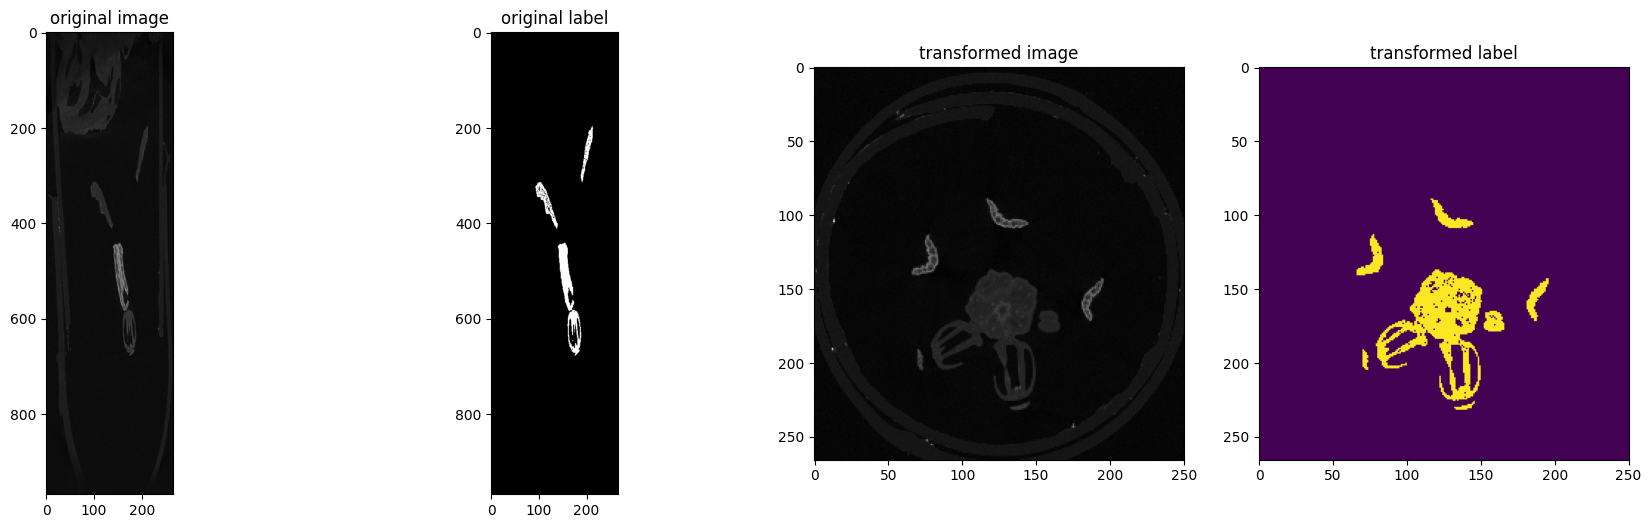

In [30]:
# Set index for image to check
## Katie to do: Still in progress
import nibabel as nib

# Coordinate system (for Nifti it's RAS)
axcodes = "RAS" # @param ["RAS"] {"allow-input":true}

# Check transformed image shape and loading
load_transform = Compose(
    [
        LoadImaged(reader = NibabelReader(), keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"], strict_check=False, channel_dim=-1),
        Orientationd(keys=["image", "label"], axcodes=axcodes),
        Spacingd(
            keys=["image", "label"],
            pixdim=(.05, .05, .05),
            mode=("bilinear", "nearest"),
        )
    ]
)

img_idx = 4 # @param {"type":"slider","min":0,"max":5,"step":1}
slice_num = 186 # @param {"type":"slider","min":0,"max":500,"step":1}

with torch.no_grad():
    # Check an image from the val dataset
    img_name = os.path.split(val_ds[img_idx]['image'].meta["filename_or_obj"])[1]
    print("Visualizing image transforms for: {} ...\n".format(img_name))

    # Get original image and label info
    img_path = data_root + '/val/images/' + img_name
    # Workaround for _crop in image filenames not in labels
    if '_crop' in img_name:
        img_name = str.split(img_name, '_crop')[0]
    idx = find_dict_idx_by_val(val_files, 'label', img_name)
    orig_data = load_transform(val_files[idx])
    orig_img_data = orig_data["image"]
    orig_img = torch.unsqueeze(orig_img_data, 0)
    print("Original image shape: ", orig_img.shape)
    orig_label_data = orig_data["label"]
    orig_label = torch.unsqueeze(orig_label_data, 0)
    print("Original label shape: ", orig_label.shape)

    # Get transformed image and label info
    img = val_ds[img_idx]["image"]
    label = val_ds[img_idx]["label"]
    print("Transformed image shape: ", img.shape)
    print("Transformed label shape: ", label.shape)

    # Plot images
    plt.figure("Orig vs Transformed", (22, 6))
    plt.subplot(1, 4, 1)
    plt.title("original image")
    plt.imshow(orig_img.numpy()[0, :, :, slice_num], cmap='gray')
    plt.subplot(1, 4, 2)
    plt.title("original label")
    plt.imshow(orig_label.numpy()[0, :, :, slice_num], cmap='gray')
    plt.subplot(1, 4, 3)
    plt.title("transformed image")
    plt.imshow(img.cpu().numpy()[0, :, :, slice_num], cmap="gray")
    plt.subplot(1, 4, 4)
    plt.title("transformed label")
    plt.imshow(label.cpu().numpy()[0, :, :, slice_num])

    plt.show()

Visualizing image transforms for: thecac_fbg_cg_220622_07_cropped.nii.gz ...

Original image shape:  torch.Size([1, 1, 266, 251, 336])
Transformed image shape:  torch.Size([1, 1, 266, 251, 336])


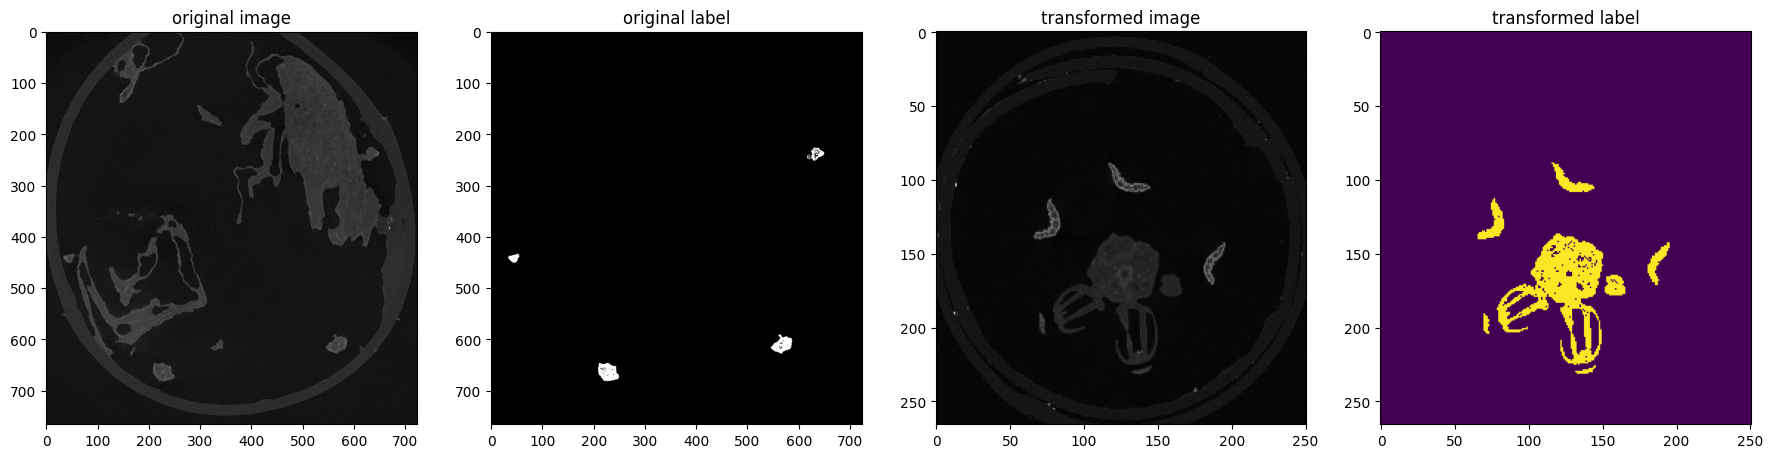

In [31]:
# Set index for image to check
## Katie to do: Still in progress
import nibabel as nib

img_idx = 4 # @param {"type":"slider","min":0,"max":5,"step":1}
slice_num = 186 # @param {"type":"slider","min":0,"max":500,"step":1}

with torch.no_grad():
    # Check an image from the val dataset
    img_name = os.path.split(val_ds[img_idx]['image'].meta["filename_or_obj"])[1]
    print("Visualizing image transforms for: {} ...\n".format(img_name))

    # Get original image and label info
    img_path = data_root + '/val/images/' + img_name
    # Workaround for _crop in image filenames not in labels
    if '_crop' in img_name:
        img_name = str.split(img_name, '_crop')[0]
    idx = find_dict_idx_by_val(val_files, 'label', img_name)
    label_path = val_files[idx]['label']
    orig_img = nib.load(img_path)
    orig_img_data = orig_img.get_fdata()
    orig_label = nib.load(label_path)
    orig_label_data = orig_label.get_fdata()

    # Get transformed image and label info
    img = val_ds[img_idx]["image"]
    label = val_ds[img_idx]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    print("Original image shape: ", val_inputs.shape)
    val_labels = torch.unsqueeze(label, 1).cuda()
    print("Transformed image shape: ", val_labels.shape)

    # Plot images
    plt.figure("Orig vs Transformed", (22, 6))
    plt.subplot(1, 4, 1)
    plt.title("original image")
    plt.imshow(orig_img_data[:, :, slice_num], cmap='gray')
    plt.subplot(1, 4, 2)
    plt.title("original label")
    plt.imshow(orig_label_data[:, :, slice_num], cmap='gray')
    plt.subplot(1, 4, 3)
    plt.title("transformed image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_num], cmap="gray")
    plt.subplot(1, 4, 4)
    plt.title("transformed label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_num])

    plt.show()

Tranformed train image shape: torch.Size([96, 96, 96]), label shape: torch.Size([96, 96, 96])


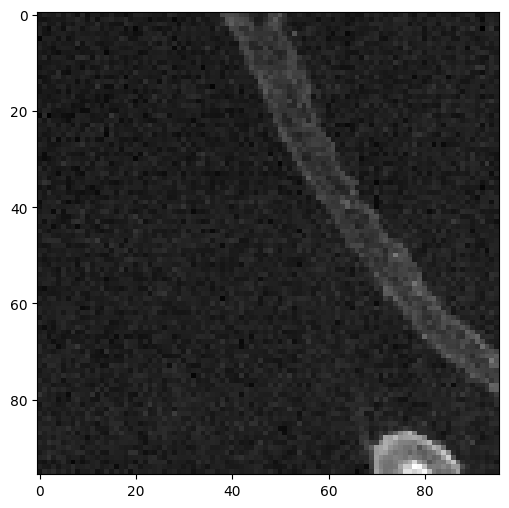

In [32]:
#@title Check a transformed image from the train dataset

# Check an image from the train dataset
demo_train_data = first(train_loader)
image, label = demo_train_data["image"][0][0], demo_train_data["label"][0][0]
print("Tranformed train image shape: {}, label shape: {}".format(image.shape, label.shape))
slice_num = 52 # @param {"type":"slider","min":0,"max":96,"step":1}

plt.figure("image", (18, 6))
plt.imshow(image[slice_num, :, :].detach().cpu(), cmap="gray")
plt.show()

## Train

In [33]:
#@title Set model parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

out_channels = 1 #@param
img_size = 96 #@param
feature_size = 70 # @param ["16","32","48","64","70","96"] {"type":"raw"}
hidden_size = 768 #@param
mlp_dim = 3072 #@param
num_heads = 12 #@param
norm_name = "instance" # @param ["instance","batch"]
res_block = True # @param {"type":"boolean"}
conv_block = True # @param {"type":"boolean"}
dropout_rate = 0.0 #@param

model = UNETR(
    in_channels=1,
    out_channels=out_channels,
    img_size=(img_size, img_size, img_size),
    feature_size=feature_size,
    hidden_size=hidden_size,
    mlp_dim=mlp_dim,
    num_heads=num_heads,
    proj_type="perceptron",
    norm_name=norm_name,
    conv_block=conv_block,
    res_block=res_block,
    dropout_rate=dropout_rate,
).to(device)

if out_channels > 1:
    loss_function = DiceCELoss(to_onehot_y=True, softmax=True)

else:
    loss_function = DiceCELoss(include_background=True, sigmoid=True)

torch.backends.cudnn.benchmark = True #@param
lr = 1e-6 #@param
weight_decay = 0 # @param ["1e-2","0","1e-3","1e-4"] {"type":"raw"}
amsgrad = True # @param {"type":"boolean"}
#optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=amsgrad)
optimizer = Novograd(model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=amsgrad)

In [34]:
#@title Train pipeline
# Modified from : Copyright (c) MONAI Consortium and [Apache License, Version 2.0](http://www.apache.org/licenses/LICENSE-2.0)

# Save each new training attempt results by name (TRAIN_SES_NUM)
saved_models_dir = "saved_models" # @param ["saved_models"] {"allow-input":true}
saved_model_path, TRAIN_SESS_NUM = set_saved_model_path(out_dir, saved_models_dir)

def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].to(device), batch["label"].to(device))
            #print("\nValidation input shape: ", val_inputs.shape)
            #print("\nValidation ground truth shape: ", val_labels.shape)
            val_outputs = sliding_window_inference(val_inputs, roi_size=(img_size, img_size, img_size), sw_batch_size=4, predictor=model)
            #print("\nValidation output shape: ", val_outputs.shape)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            #print("Val output convert: ", val_output_convert)
            #print("Val labels convert: ", val_labels_convert)
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))  # noqa: B038
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].to(device), batch["label"].to(device))
        #print("\nModel input shape: ", x.shape)
        logit_map = model(x)
        #print("\nModel output shape: ", logit_map.shape)
        #print("\nGround truth shape: ", y.shape)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(  # noqa: B038
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), saved_model_path)
                print(
                    "\033[32m Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}\033[0m".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "\033[33mModel Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}\033[0m".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

max_iterations = 100 #@param
eval_num = 10 #@param
post_label = Compose([AsDiscrete(n_classes=out_channels)])
post_pred = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
#post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold_values=True)])
#post_trans = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
dice_metric = DiceMetric(include_background=True, reduction="mean")
global_step = 0
dice_val_best = -0.1
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join(saved_models_dir, saved_model_path)))

print(f"\n\n\n train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

Saving trained model results to:  /content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/results/saved_models/31.pth


Training (10 / 100 Steps) (loss=1.33868):  58%|█████▊    | 11/19 [00:58<00:56,  7.10s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.1415526121854782 Current Avg. Dice: 0.1415526121854782


Training (20 / 100 Steps) (loss=1.27655):  11%|█         | 2/19 [00:21<03:33, 12.59s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.14176155626773834 Current Avg. Dice: 0.14176155626773834


Training (30 / 100 Steps) (loss=1.51756):  63%|██████▎   | 12/19 [00:49<00:47,  6.85s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.1419733464717865 Current Avg. Dice: 0.1419733464717865


Training (40 / 100 Steps) (loss=1.32307):  16%|█▌        | 3/19 [00:22<02:36,  9.77s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.14221949875354767 Current Avg. Dice: 0.14221949875354767


Training (50 / 100 Steps) (loss=1.38029):  68%|██████▊   | 13/19 [00:50<00:40,  6.82s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.14249074459075928 Current Avg. Dice: 0.14249074459075928


Training (60 / 100 Steps) (loss=1.43519):  21%|██        | 4/19 [00:23<02:07,  8.47s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.14267711341381073 Current Avg. Dice: 0.14267711341381073


Training (70 / 100 Steps) (loss=1.33512):  74%|███████▎  | 14/19 [00:50<00:33,  6.77s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.14289462566375732 Current Avg. Dice: 0.14289462566375732


Training (80 / 100 Steps) (loss=1.43351):  26%|██▋       | 5/19 [00:24<01:49,  7.85s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.14309176802635193 Current Avg. Dice: 0.14309176802635193


Training (90 / 100 Steps) (loss=1.34315):  79%|███████▉  | 15/19 [00:52<00:27,  6.99s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.14328713715076447 Current Avg. Dice: 0.14328713715076447


Training (100 / 100 Steps) (loss=1.41537):  32%|███▏      | 6/19 [00:24<01:36,  7.39s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.14343269169330597 Current Avg. Dice: 0.14343269169330597


Training (110 / 100 Steps) (loss=1.35092):  84%|████████▍ | 16/19 [00:52<00:20,  6.79s/it]

 Model Was Saved ! Current Best Avg. Dice: 0.1436474770307541 Current Avg. Dice: 0.1436474770307541


Training (113 / 100 Steps) (loss=1.43330): 100%|██████████| 19/19 [00:55<00:00,  2.91s/it]


<All keys matched successfully>

In [36]:
#@title Convert notebook to txt file and save for track record of train parameters for each saved model

# Define train notebooks dir
train_nbs_path = "train_notebooks"
train_nbs_dir = os.path.join(out_dir, train_nbs_path)
if not os.path.exists(train_nbs_dir):
    os.mkdir(train_nbs_dir)


# Save train notebook to text file
train_nb_path = train_nbs_dir + '/' + str(TRAIN_SESS_NUM)

# Original train notebook (.ipynb) location
orig_nb_dir = "/content/drive/MyDrive/'Colab Notebooks'/" # @param ["/content/drive/MyDrive/'Colab Notebooks'/"] {"allow-input":true}
fn = "Cacao_Whole_Flower_Seg_unetr.ipynb" # @param ["Whole_Flower_Seg_unetr_newpipeline_abdomendata.ipynb"] {"allow-input":true}
fpath = orig_nb_dir + fn

# Convert train notebook to text file
%cd $orig_nb_dir
!jupyter nbconvert --output-dir=$train_nb_path --to python $fpath

print("Colab notebook: {} converted to text file: {} for use as train parameters log".format(fpath, train_nb_path))

/content/drive/MyDrive/Colab Notebooks
[NbConvertApp] Making directory /content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/results/train_notebooks/31
[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Cacao_Whole_Flower_Seg_unetr.ipynb to python
[NbConvertApp] Writing 32356 bytes to /content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/results/train_notebooks/31/Cacao_Whole_Flower_Seg_unetr.py
Colab notebook: /content/drive/MyDrive/'Colab Notebooks'/Cacao_Whole_Flower_Seg_unetr.ipynb converted to text file: /content/drive/MyDrive/Miami_21/project/manuscripts/CV_for_flower_CT/analysis/data/results/train_notebooks/31 for use as train parameters log


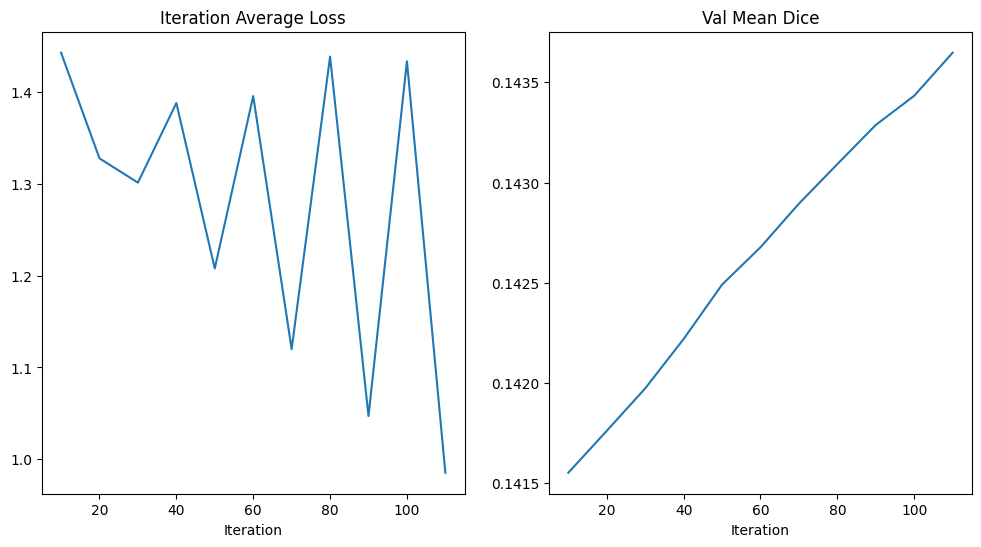

<Figure size 640x480 with 0 Axes>

In [37]:
#@title Plot train Loss and mean DICE and save results to file
# Modified from : Copyright (c) MONAI Consortium and [Apache License, Version 2.0](http://www.apache.org/licenses/LICENSE-2.0)

# Plot figures
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

# Define train graphs dir
train_graphs_dir = os.path.join(out_dir, "train_graphs")
if not os.path.exists(train_graphs_dir):
    os.mkdir(train_graphs_dir)

# Save train graph to file
train_graph_path = train_graphs_dir + TRAIN_SESS_NUM + '.png'
plt.savefig(train_graph_path)

<ipython-input-106-2ae27bf005e0>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(saved_model_path))


torch.Size([1, 1, 266, 251, 336])
torch.Size([1, 1, 266, 251, 336])
torch.Size([1, 1, 266, 251, 336])


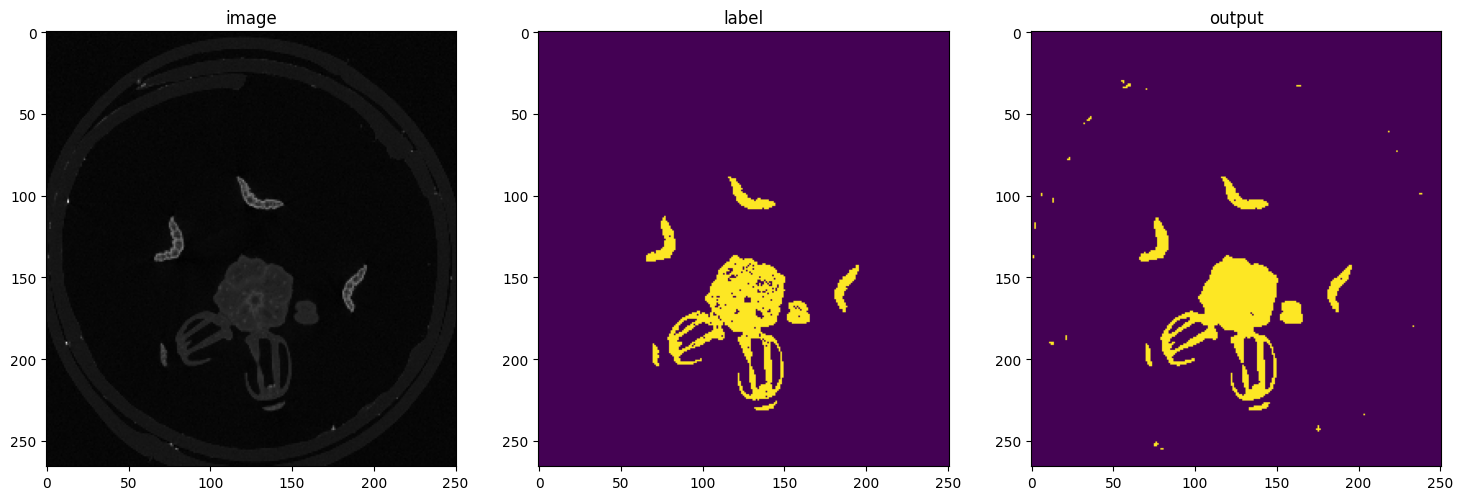

In [ ]:
#@title Plot model prediction vs ground truth

val_img_idx = 4 # @param {"type":"slider","min":0,"max":5,"step":1}
slice_num = 186 # @param {"type":"slider","min":0,"max":500,"step":1}

# Load in saved model
saved_models_dir = os.path.join(out_dir, "saved_models")
use_last_model = True # @param {"type":"boolean"}
if use_last_model:
    last_attempt = !ls $saved_models_dir | tail -n 1
    TRAIN_SESS_NUM = int(os.path.splitext(last_attempt[0])[0])
    if TRAIN_SESS_NUM < 10:
        TRAIN_SESS_NUM = '0' + str(TRAIN_SESS_NUM)
    else:
        TRAIN_SESS_NUM = str(TRAIN_SESS_NUM)
else:
    TRAIN_SESS_NUM = "02" # @param ["01","02","03"] {"allow-input":true}

saved_model_path = saved_models_dir + '/' + TRAIN_SESS_NUM + ".pth"
model.load_state_dict(torch.load(saved_model_path))

# Show model predictions on image
model.eval()
with torch.no_grad():
    # Check an image from the val dataset
    img_name = os.path.split(val_ds[val_img_idx]['image'].meta["filename_or_obj"])[1]
    img = val_ds[val_img_idx]["image"]
    label = val_ds[val_img_idx]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    print(val_inputs.shape)
    val_labels = torch.unsqueeze(label, 1).cuda()
    print(val_labels.shape)
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    print(val_outputs.shape)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_num], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_num])
    plt.subplot(1, 3, 3)
    plt.title("output")
    if out_channels > 1:
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, 0, :, :, slice_num])
    else:
        plt.imshow((val_outputs > 0.5).int().detach().cpu()[0, 0, :, :, slice_num])
    plt.show()